# Self-Learning Algorithm for Semi-Supervised Learning
#### Steps taken from tutorial(check README)
1. Train the classifier with the existing labeled dataset.
2. Predict a portion of samples using the trained classifier.
3. Add the predicted data with high confidentiality score into training set.
4. Repeat all steps above.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

c:\Users\jereb\anaconda3\envs\tensor\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\jereb\anaconda3\envs\tensor\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\jereb\anaconda3\envs\tensor\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def create_model():
    model = Sequential()
    model.add(Embedding(8000, 32, input_length=245))
    model.add(LSTM(20))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [3]:
def get_new_train_data(predictions, fold_n):
    X_new = list()
    y_new = list()
    
    for i, prediction in enumerate(predictions):
        #our activation function will drop data when
        #output is in between .05 and .95
        if prediction > 0.95 or prediction < 0.05:
            X_new.append(X_fold[fold_n][i])
            y_new.append(np.argmax(prediction))
    
    return np.array(X_new), np.array(y_new)

In [4]:
def join_shuffle(X_train, y_train, X_new, y_new):
    X_train = np.vstack((X_train, X_new))
    y_train = np.append(y_train, y_new)
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    return X_train[indices], y_train[indices]
 

## Load Data & preprocessing
First we are going to load all of our required modules and dataset. We will be using IMDB movie reviews. With our model we are going to determine if a text is negative or positive review (sentiment analysis)

In [5]:
#tuple collection of unchangeable, ordered data,
#going to store dataset into tuples here with load_data function
(X, y), (X_test, y_test) = imdb.load_data(num_words=8000)

In [6]:
# thisTuple = (1,2)
# (z,f) = ((1,2),(4,5))
# for x in z:
#     print(x)
# for y in f:
#     print(y)


In [7]:
# test to see tuples
# print(X[0])
# print(X_test[0])

every review has different amount of words, which is a problem because model will expect a fixed input size.
Solve this with pad_sequences() function from keras. which will limit text length.
Below will iterate over movie reviews, find the average, and limit text that way

In [8]:
reviewLengths = list()
for x in X:
    reviewLengths.append(len(x))

print(np.mean(reviewLengths))

X_pad = pad_sequences(X,maxlen=245)
X_test_pad = pad_sequences(X_test,maxlen=245)


238.71364


## Data splitting
* With this project all of the reviews are labeled. To simulate semi-supervised learning, then the assumption is that part of the reviews are labeled. We are going to train the model on small amount of data, and with high confidentiality from this, we are going to use this and the previous 'unlabeled' data to retrain model.
* To split data with a *kFold* object from Sklearn. We are going to split data into 5 different folds, and fold 0 will be our 'first go' at training our model because it is assumed fold 0 is our only labeled data from the dataset

In [9]:
# split data into 5 folds, shuffle data before dividing data into folds
kf = KFold(n_splits=5, shuffle=True) 

X_fold = list()
y_fold = list()

#loop over kf and split into different folds
for _, fold in kf.split(X_pad):
    X_fold.append(X_pad[fold])
    y_fold.append(y[fold])

#storefolds into numpy array
X_fold = np.array(X_fold)
y_fold = np.array(y_fold)

# The 0th fold will be our known labeled, the rest folds are assumed to be unlabeled
X_train = X_fold[0]
y_train = y_fold[0]

# Model training
* Done using LSTM-Based neural network **(LSTM)**. LSTM is a type of RNN. What is RNN? It is a type of artificial neural network that take information from previous inputs to influence current input and output. RNN's output depend on prior sequential elements. 
* LSTM tries to mimick the human brain, handling previous knowledge to handle learning long-term dependencies in short-term data, suitable for NLP.

### Recap
* data folds stored in X_fold[0] to X_fold[4].
* X_train and y_train is taken from first fold array and pretend its our only labeled data

## going to initialize model and apply fit. 
## Use last 1000 reviews instead of all 5000.
* to see if model overfits(happens when model cannot perform accurately against unseen data)
* use 2 epochs for see overfitness

In [10]:
model = create_model()
model.fit(X_train[:-1000], y_train[:-1000], epochs=2, 
          validation_data=(X_train[-1000:], y_train[-1000:]))
          
predictions = model.predict(X_fold[1])

Epoch 1/2
125/125 [==============================] - 4s 17ms/step - loss: 0.6589 - acc: 0.6255 - val_loss: 0.5360 - val_acc: 0.7760
Epoch 2/2
157/157 [==============================] - 1s 5ms/step


* this model is semi trained, in order to better model we must train rest of folds and use those predictions as more labeled data
* **This isn't the best idea though**
* perform filtering method called **pseudo-labeling**
* this will result predictions with low confidentiality score to be dropped from folds since these have a chance of not being correct prediction-wise

### join new data with existing training data

In [11]:
X_new, y_new = get_new_train_data(predictions, 1)
X_train, y_train = join_shuffle(X_train, y_train, X_new, y_new)

### train model again

In [12]:
model = create_model()
model.fit(X_train[:-1000], y_train[:-1000], epochs=3, 
          validation_data=(X_train[-1000:], y_train[-1000:]))

# Predict samples in fold 2
predictions = model.predict(X_fold[2])

# Filter out samples in fold 2
X_new, y_new = get_new_train_data(predictions, 2)

# Concatenate new data to X_train and y_train
X_train, y_train = join_shuffle(X_train, y_train, X_new, y_new)

Epoch 1/3
137/137 [==============================] - 4s 20ms/step - loss: 0.6551 - acc: 0.6157 - val_loss: 0.5413 - val_acc: 0.7650
Epoch 2/3
137/137 [==============================] - 2s 14ms/step - loss: 0.4810 - acc: 0.8153 - val_loss: 0.4277 - val_acc: 0.8140
Epoch 3/3
157/157 [==============================] - 1s 5ms/step


### use data from fold 0,1,2 to train new model again

In [13]:

history = model.fit(X_train, y_train, epochs=2, 
          validation_data=(X_test_pad, y_test))

Epoch 1/2
206/206 [==============================] - 7s 35ms/step - loss: 0.2458 - acc: 0.9170 - val_loss: 0.4061 - val_acc: 0.8201
Epoch 2/2
206/206 [==============================] - 7s 35ms/step - loss: 0.1881 - acc: 0.9436 - val_loss: 0.4595 - val_acc: 0.8204


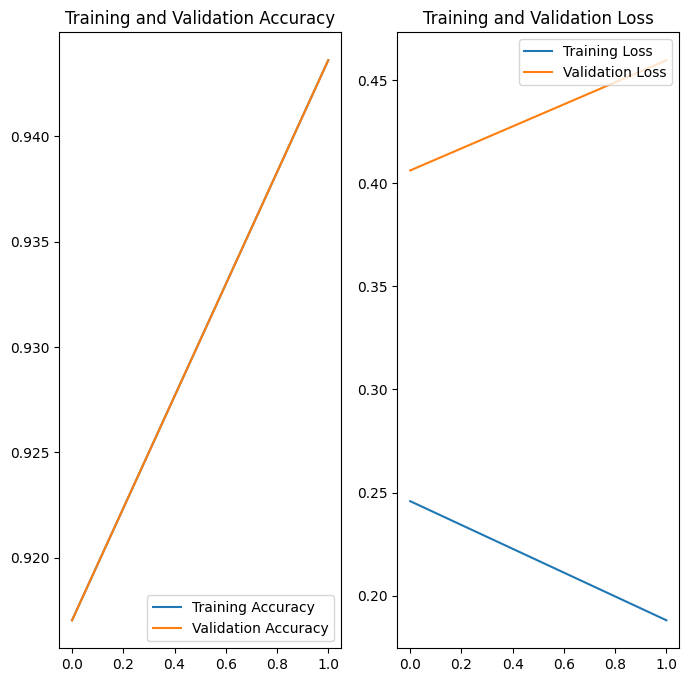

In [14]:
acc = history.history['acc']
val_acc = history.history['acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()